In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : lightGBM   ######################## 
########################       Polarity on Reviews      ########################
########################       Negative vs Positive     ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM


In [4]:
# Clone lightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [5]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM

! mkdir build

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [6]:
# Compile
! cmake -DUSE_GPU=1 #avoid ..
! make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


CMake Error: The current CMakeCache.txt directory /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeCache.txt is different than the directory /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM where CMakeCache.txt was created. This may result in binaries being created in the wrong place. If you are not sure, reedit the CMakeCache.txt
CMake Error: The source "/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeLists.txt" does not match the source "/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/CMakeLists.txt" used to generate cache.  Re-run cmake with a different source directory.
-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-

In [7]:
! sudo apt-get -y install python-pip

! sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna gensim==3.8.3 datetime plotly matplotlib==3.4.2 seaborn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [8]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package

! sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.txt -> build/lib/lightgbm
running install_lib
copying build/lib/lightgbm/VERSION.txt -> /usr/lib/python3.7/site-packages/lightgbm
INFO:LightGBM:Installing lib_lightgbm from: ['/content/drive/MyDrive/Yelp_Reviews/ML/Classificati

In [9]:
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [10]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat May 14 19:17:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [11]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [12]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [13]:
# Read tokenized reviews with stars filtered for Sentiment
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,"[order, chicken, finger, sub, honey, mustard, ...",Negative,3.0
3,"[dedicated, loving, memory, gary, feldman, gre...",Negative,5.0
12,"[absolutely, horrible, thought, would, order, ...",Negative,1.0
15,"[found, better, chicken, finger, know, inside,...",Negative,4.0
20,"[amazing, everything, tried, disappoint, chick...",Negative,5.0


In [14]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [15]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,cleanReview,sentiment,stars_reviews
index,,,
1,"[""order"", ""chicken"", ""finger"", ""sub"", ""honey"",...",Negative,3.0
3,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel...",Negative,5.0
12,"[""absolutely"", ""horrible"", ""thought"", ""would"",...",Negative,1.0
15,"[""found"", ""better"", ""chicken"", ""finger"", ""know...",Negative,4.0
20,"[""amazing"", ""everything"", ""tried"", ""disappoint...",Negative,5.0


In [16]:
# Recode to binary
df = df.copy()
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [17]:
df = df.copy()
df['sentiment'] = df['sentiment'].astype('int')
df.dtypes

cleanReview       object
sentiment          int64
stars_reviews    float64
dtype: object

In [18]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [19]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [20]:
  # Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [21]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [22]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f67fbbe5b10>)])

In [23]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL


In [24]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [25]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [26]:
################################################################################
######################     lightGBM Optuna HPO  ################################
######################         100 trials       ################################
################################################################################
def lgb_hpo(trial):
    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),

        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, step=10),       

        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)


In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-05-14 14:13:57.011785
[LightGBM] [Warning] lambda_l2 is set=4.999447538508179e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.999447538508179e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=0.0001484292741448731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001484292741448731
[LightGBM] [Warning] min_gain_to_split is set=4.493516448079726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.493516448079726
- Validation logloss: 0.2795612525955914
- Validation logloss: 0.6878158823790498
- Validation logloss: 0.18122612741879876
- Validation logloss: 0.20811512057821
- Validation logloss: 0.6792529992489712
- Validation logloss: 0.4761709820964655
- Validation logloss: 0.6928661

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq':'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_lambda_l1':'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2':'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples':'min_child_samples'}, inplace=True)
trials_df.rename(columns={'params_min_gain_to_split':'min_gain_to_split'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves':'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
64         64  0.156697 2022-05-14 16:19:22.200275 2022-05-14 16:21:20.850815   
32         32  0.156775 2022-05-14 15:16:24.446051 2022-05-14 15:18:44.092495   
31         31  0.156805 2022-05-14 15:14:04.600215 2022-05-14 15:16:24.445913   
8           8  0.156833 2022-05-14 14:27:31.005072 2022-05-14 14:29:38.166842   
41         41  0.156845 2022-05-14 15:34:48.033415 2022-05-14 15:36:59.764546   
..        ...       ...                        ...                        ...   
9           9  0.688271 2022-05-14 14:29:38.166956 2022-05-14 14:31:08.147068   
33         33  0.690566 2022-05-14 15:18:44.092624 2022-05-14 15:21:12.160115   
18         18  0.692085 2022-05-14 14:46:07.810716 2022-05-14 14:48:10.132489   
87         87  0.692687 2022-05-14 17:01:35.436010 2022-05-14 17:03:34.308213   
6           6  0.692866 2022-05-14 14:24:09.798452 2022-05-14 14:25:44.332003   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.

fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [27]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions


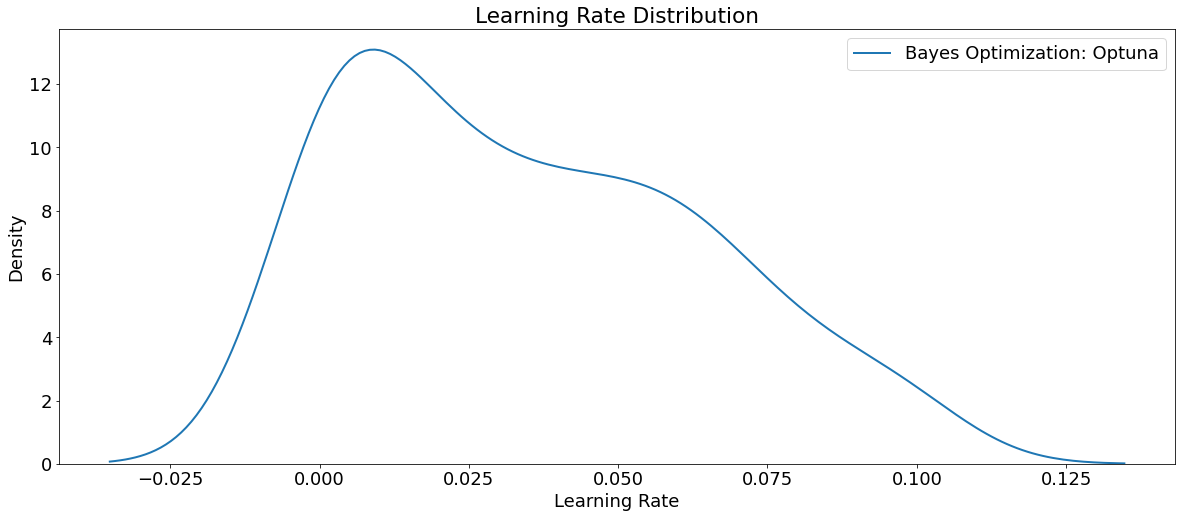

In [28]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

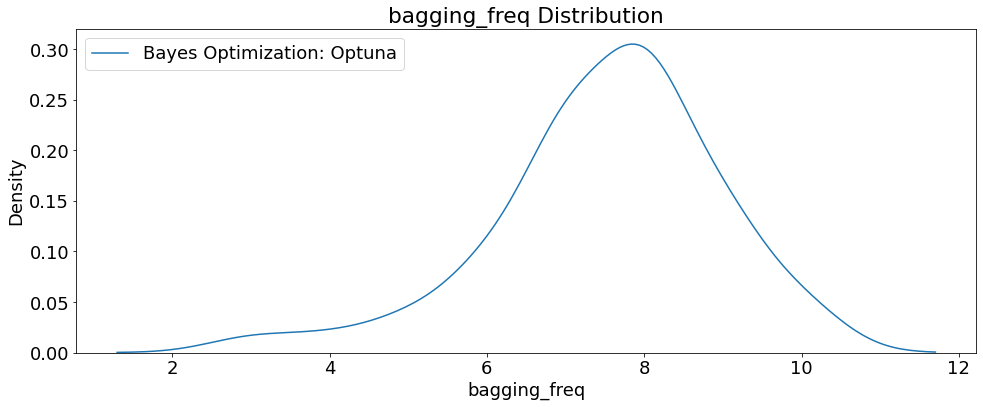

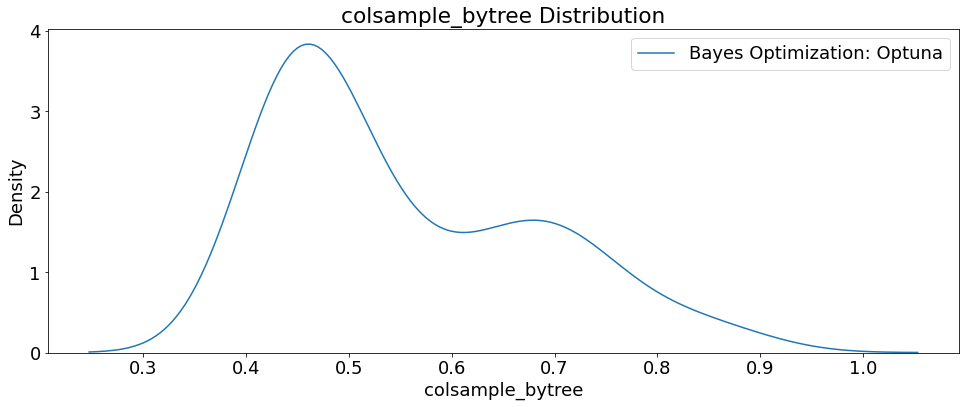

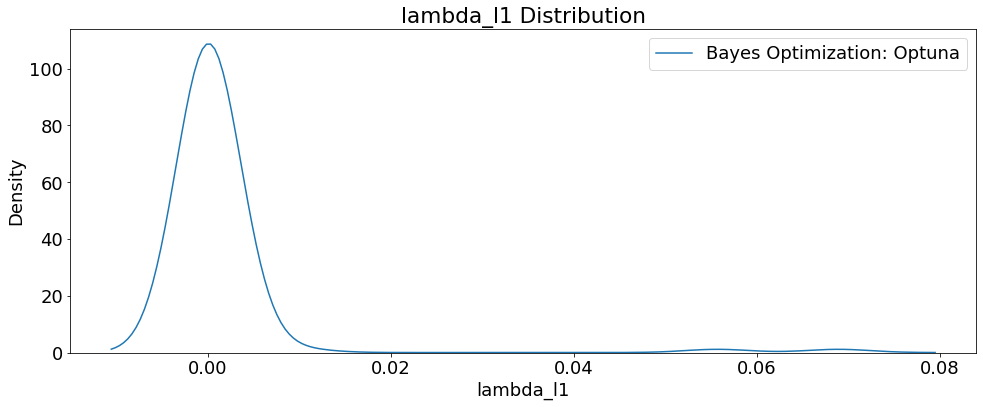

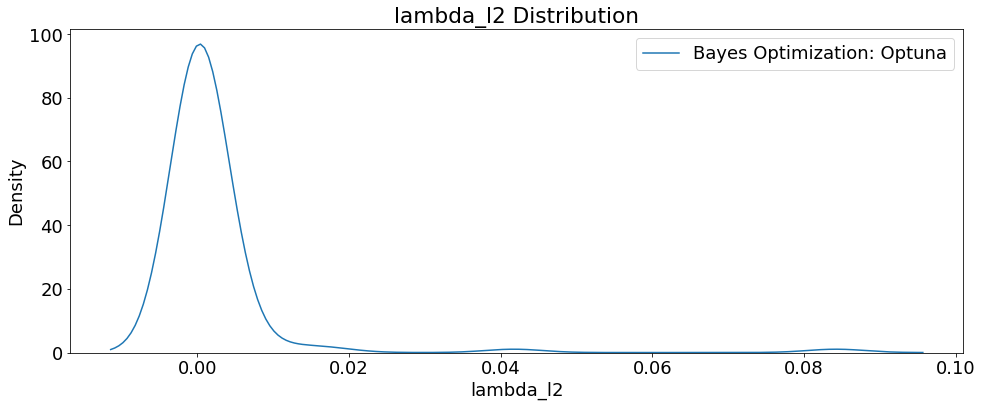

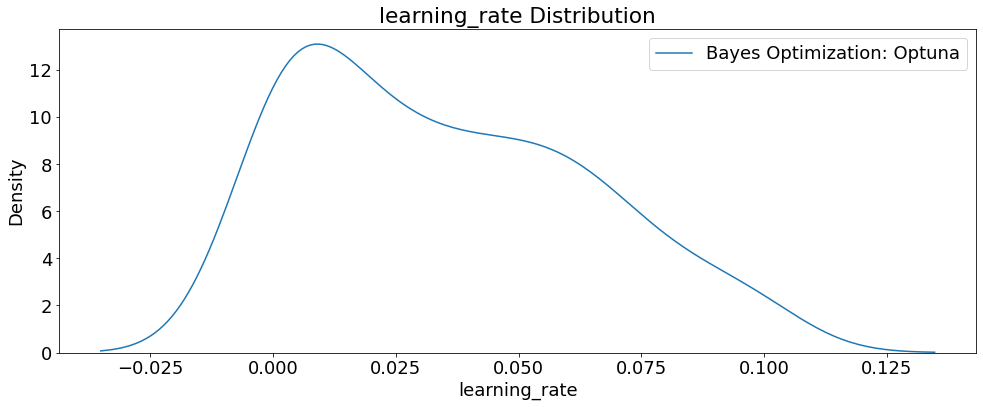

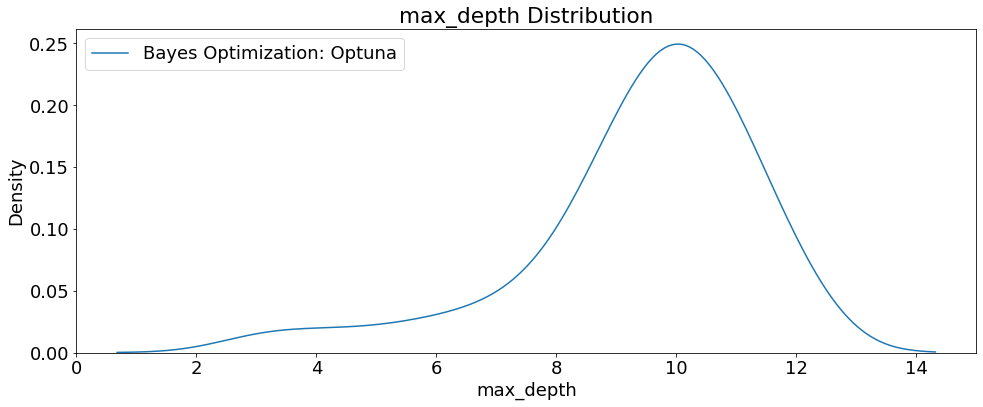

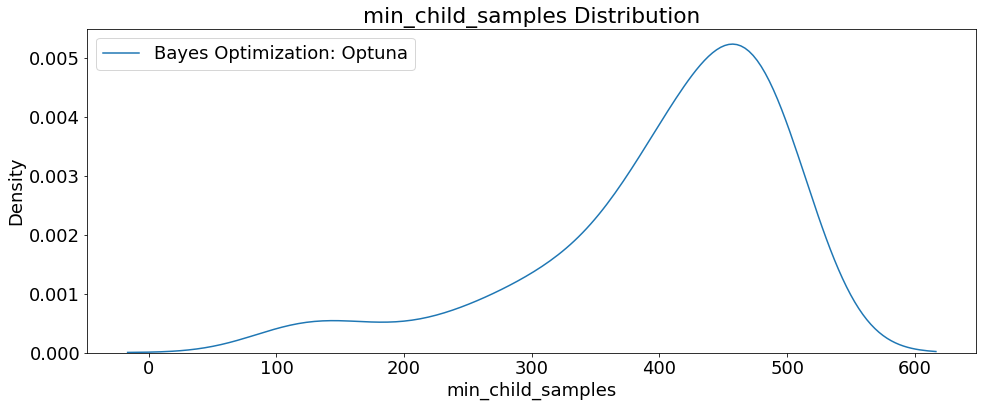

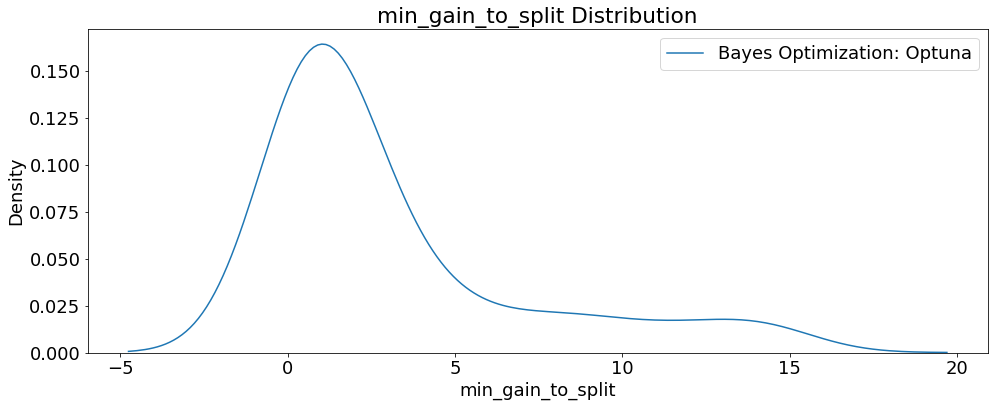

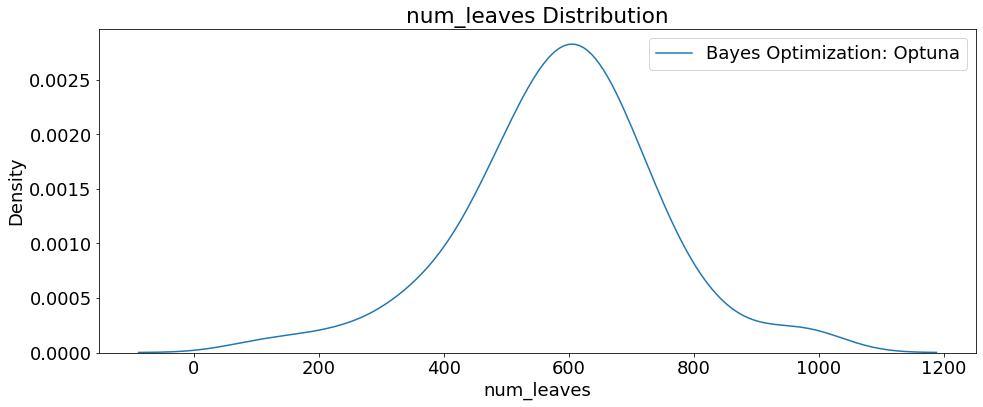

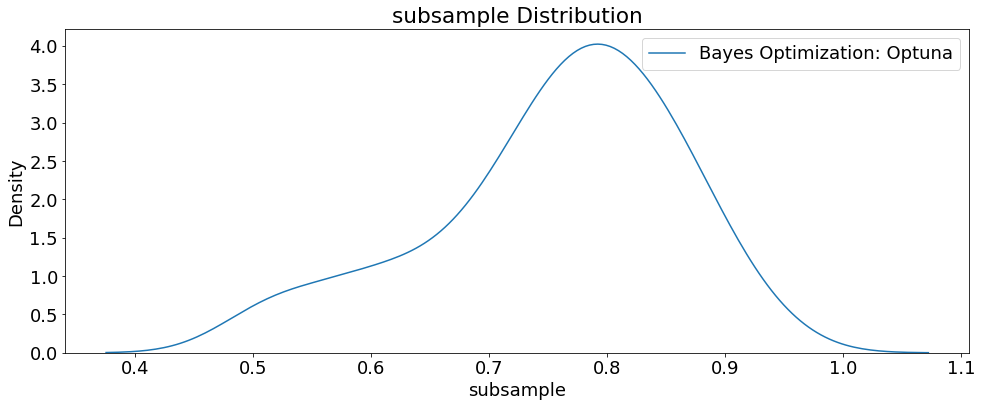

In [29]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

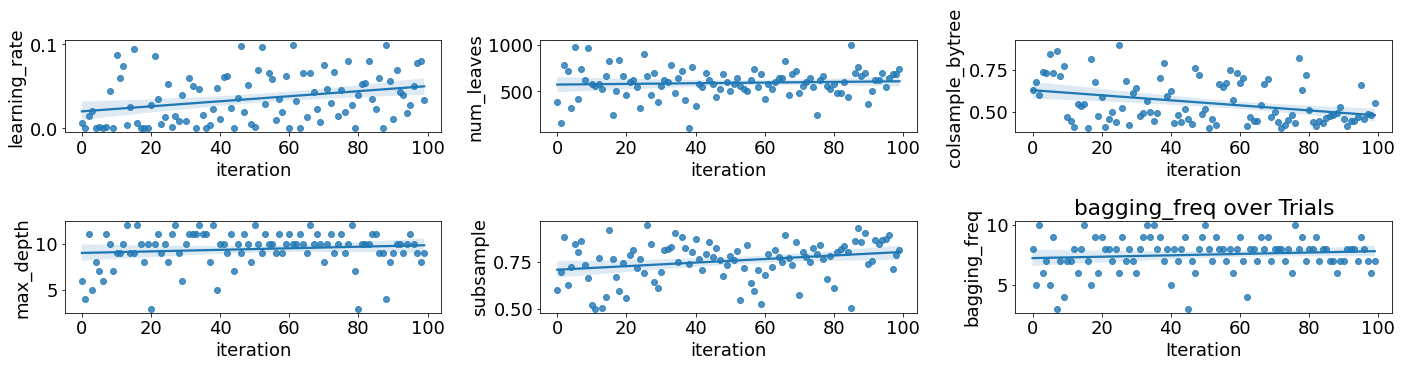

In [30]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 3, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



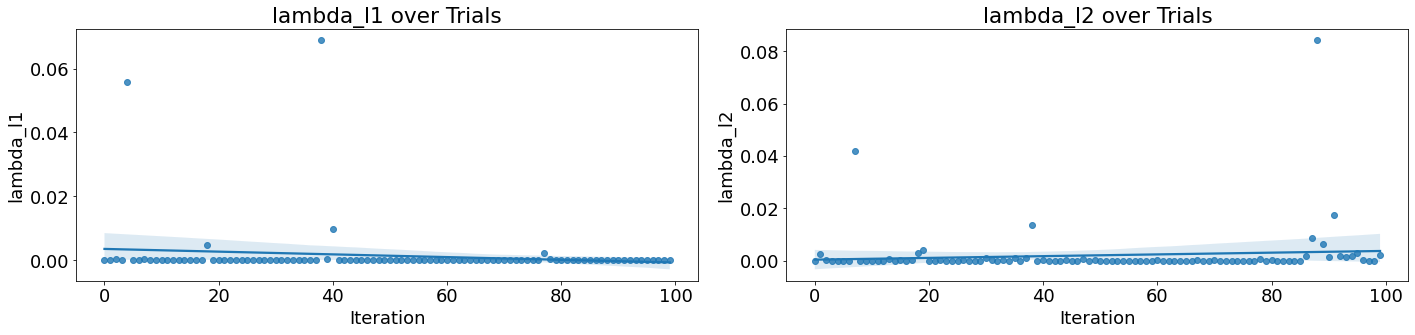

In [31]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL/

study = joblib.load('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 8,
 'colsample_bytree': 0.4421328088439629,
 'lambda_l1': 1.8108593985768235e-08,
 'lambda_l2': 1.3983527803690125e-06,
 'learning_rate': 0.06531163131919056,
 'max_depth': 10,
 'metric': 'binary_error',
 'min_child_samples': 330,
 'min_gain_to_split': 0.41480137178119253,
 'n_estimators': 500,
 'num_leaves': 640,
 'random_state': 42,
 'subsample': 0.7760295887433482}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/Model_PKL


In [ ]:
label = df[['sentiment']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = lgb.LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_sentPol_w2vReviewStars.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_sentPol_w2vReviewStars.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    331949
           1       0.96      0.96      0.96    331950

    accuracy                           0.96    663899
   macro avg       0.96      0.96      0.96    663899
weighted avg       0.96      0.96      0.96    663899



Confusion matrix: Train
[[319265  12684]
 [ 13372 318578]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     82988
           1       0.94      0.94      0.94     82987

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78063  4925]
 [ 5096 77891]]


Accuracy score: train: 0.961, test: 0.940
Precision score: train: 0.962, test: 0.941
Recall score: 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/SentimentPolarity/trialOptions


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93962 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    64
logloss                                0.156697
datetime_start       2022-05-14 16:19:22.200275
datetime_complete    2022-05-14 16:21:20.850815
duration                 0 days 00:01:58.650540
bagging_freq                                  8
colsample_bytree                       0.442133
lambda_l1                                   0.0
lambda_l2                              0.000001
learning_rate                          0.065312
max_depth                                    10
min_child_samples                           330
min_gain_to_split                      0.414801
n_estimators                                500
num_leaves                                  640
subsample                               0.77603
state                                  COMPLETE
Name: 0, dtype: object
